# Ad click prediction

## Introduction

The goal fo the project is to predict who is likely to click on the ad

Key steps include:
    1. Exploratory analysis and feature extraction
    2. Building a model/ multiple models
    3. Understand the data in depth from feature importance

## Load Libraries

In [1]:
import os 
from pandas import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## Load Data and Examine Data

In [2]:
ad = read_csv('advertising.csv')

ad.head(10)

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0
5,59.99,23,59761.56,226.74,Sharable client-driven software,Jamieberg,1,Norway,2016-05-19 14:30:17,0
6,88.91,33,53852.85,208.36,Enhanced dedicated support,Brandonstad,0,Myanmar,2016-01-28 20:59:32,0
7,66.00,48,24593.33,131.76,Reactive local challenge,Port Jefferybury,1,Australia,2016-03-07 01:40:15,1
8,74.53,30,68862.00,221.51,Configurable coherent function,West Colin,1,Grenada,2016-04-18 09:33:42,0
9,69.88,20,55642.32,183.82,Mandatory homogeneous architecture,Ramirezton,1,Ghana,2016-07-11 01:42:51,0


Feature	Description
1. Daily Time Spent on a Site	Time spent by the user on a site in minutes.
2. Age	Customer's age in terms of years.
3. Area Income	Average income of geographical area of consumer.
4. Daily Internet Usage	Avgerage minutes in a day consumer is on the internet.
5. Ad Topic Line	Headline of the advertisement.
6. City	City of the consumer.
7. Male	Whether or not a consumer was male.
8. Country	Country of the consumer.
9. Timestamp	Time at which user clicked on an Ad or the closed window.
10. Clicked on Ad	0 or 1 is indicated clicking on an Ad.

In [3]:
ad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
Daily Time Spent on Site    1000 non-null float64
Age                         1000 non-null int64
Area Income                 1000 non-null float64
Daily Internet Usage        1000 non-null float64
Ad Topic Line               1000 non-null object
City                        1000 non-null object
Male                        1000 non-null int64
Country                     1000 non-null object
Timestamp                   1000 non-null object
Clicked on Ad               1000 non-null int64
dtypes: float64(3), int64(3), object(4)
memory usage: 78.2+ KB


In [4]:
#looks like most column are in correct data type except the timestamp

ad['Timestamp']=to_datetime(ad['Timestamp'])
ad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
Daily Time Spent on Site    1000 non-null float64
Age                         1000 non-null int64
Area Income                 1000 non-null float64
Daily Internet Usage        1000 non-null float64
Ad Topic Line               1000 non-null object
City                        1000 non-null object
Male                        1000 non-null int64
Country                     1000 non-null object
Timestamp                   1000 non-null datetime64[ns]
Clicked on Ad               1000 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(3), object(3)
memory usage: 78.2+ KB


In [5]:
#summarise numerical variables
ad.describe()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Clicked on Ad
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,65.000200,36.009000,55000.000080,180.000100,0.481000,0.50000
std,15.853615,8.785562,13414.634022,43.902339,0.499889,0.50025
min,32.600000,19.000000,13996.500000,104.780000,0.000000,0.00000
25%,51.360000,29.000000,47031.802500,138.830000,0.000000,0.00000
50%,68.215000,35.000000,57012.300000,183.130000,0.000000,0.50000
75%,78.547500,42.000000,65470.635000,218.792500,1.000000,1.00000
max,91.430000,61.000000,79484.800000,269.960000,1.000000,1.00000


Couple notes from the initial look:
1. The mean and median are very close to each other, indicating our data is not very skewed
2. Clicks on ad probability is ~50% - usually data of this nature are imbalanced and require undersampling or oversampling technique, but here this issue has already been taken care of

In [6]:
for v in ad.columns:
    if ad[v].dtypes=='object':
        print('There are {} unique value in variable {}'.format(len(ad[v].unique()), v))

There are 1000 unique value in variable Ad Topic Line
There are 969 unique value in variable City
There are 237 unique value in variable Country


The categorical variable is very sparse - ad topic is unique for reach observation and city is mostly too. That means we cannot use these two variables as model input, let's take a look of the text to see if we can aggregate it somehow.

In [7]:
ad['Ad Topic Line'].values
# doesn't seem to be useful

array(['Cloned 5thgeneration orchestration',
       'Monitored national standardization',
       'Organic bottom-line service-desk',
       'Triple-buffered reciprocal time-frame',
       'Robust logistical utilization', 'Sharable client-driven software',
       'Enhanced dedicated support', 'Reactive local challenge',
       'Configurable coherent function',
       'Mandatory homogeneous architecture',
       'Centralized neutral neural-net',
       'Team-oriented grid-enabled Local Area Network',
       'Centralized content-based focus group',
       'Synergistic fresh-thinking array',
       'Grass-roots coherent extranet',
       'Persistent demand-driven interface',
       'Customizable multi-tasking website', 'Intuitive dynamic attitude',
       'Grass-roots solution-oriented conglomeration',
       'Advanced 24/7 productivity',
       'Object-based reciprocal knowledgebase',
       'Streamlined non-volatile analyzer',
       'Mandatory disintermediate utilization',
       'Futur

## Distribution and relationship between numeric varaibles

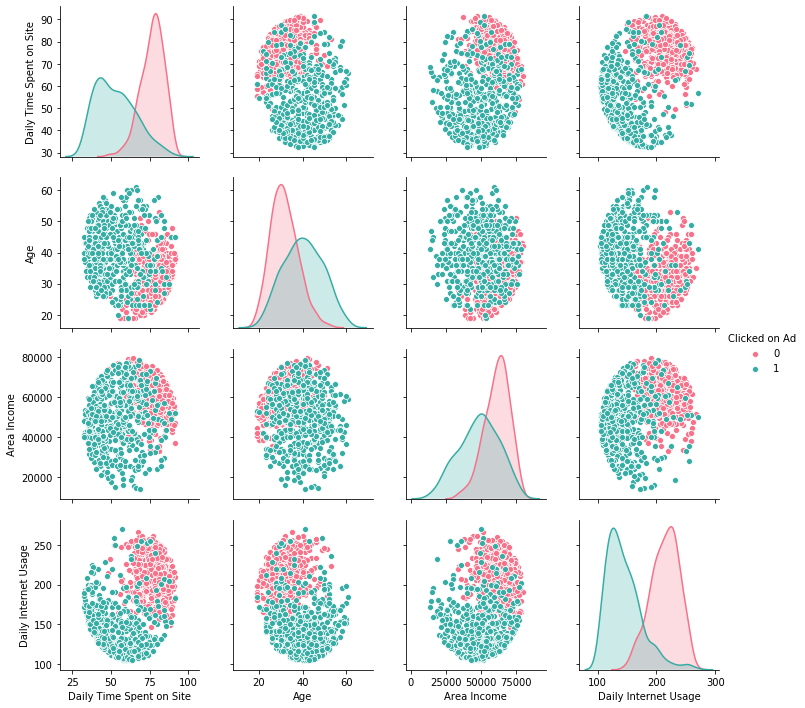

In [8]:
#create pair plot with hue by clicks

sns.pairplot(ad, hue ='Clicked on Ad', vars=['Daily Time Spent on Site', 'Age', 
                                             'Area Income', 'Daily Internet Usage'],
            palette='husl')

Pairplot represetns the relationship between our explanatory variables and our target. We can see that people send less time on the internet and less time on the site, relatively aged who has less income are more likely to click. And daily internet usage and daily time spent on site seem to be extremly useful in predicting click action. Need to investigate how much they're correlated.

In [9]:
ad['Month']=ad['Timestamp'].dt.month #create month
ad['Day']=ad['Timestamp'].dt.day # create day
ad['Hour']=ad['Timestamp'].dt.hour # create hour
ad['Weekday']=ad['Timestamp'].dt.dayofweek # create dat of week


ad['Date']=ad['Timestamp'].dt.date

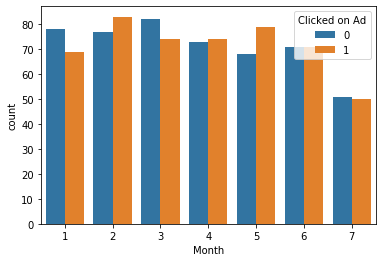

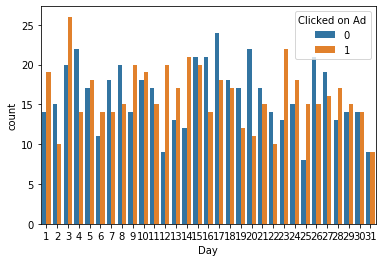

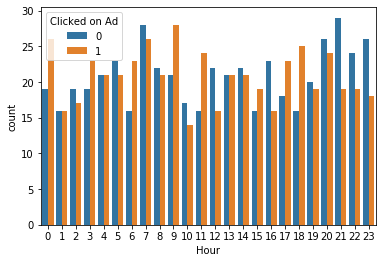

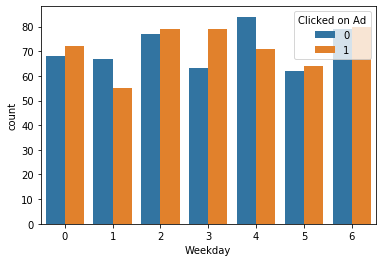

In [25]:
time_attributes=['Month','Day','Hour','Weekday']
for t in time_attributes:
    ax = sns.countplot(t, hue="Clicked on Ad", data=ad)
    plt.show()

## Correlation between variables

(10.0, 0.0)

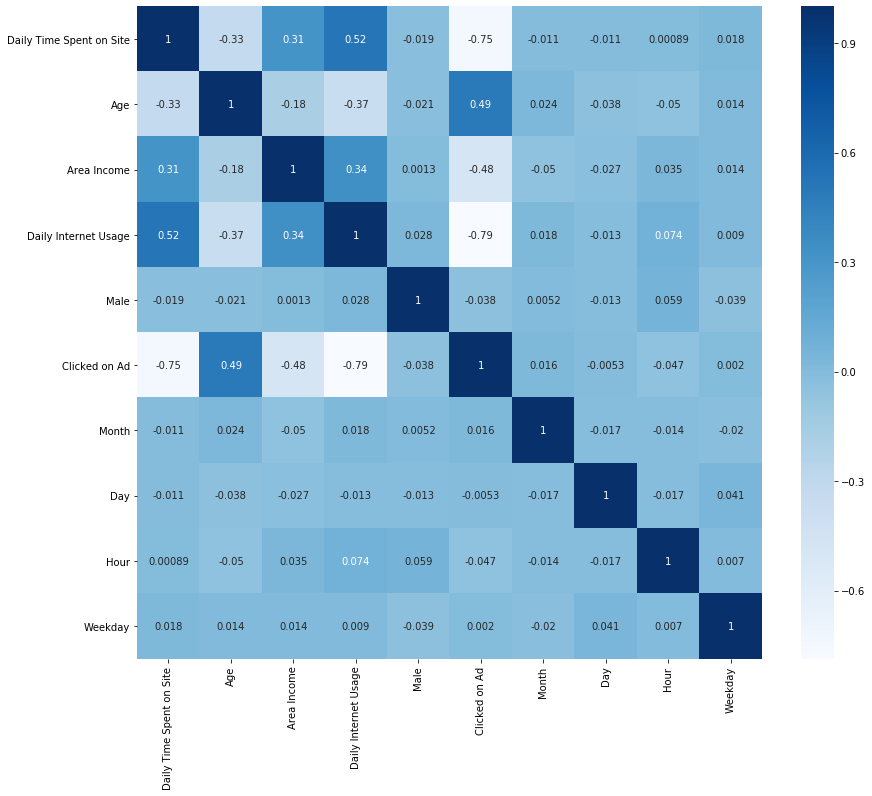

In [11]:
fig = plt.figure(figsize = (14,12))
ax=sns.heatmap(ad.corr(), cmap='Blues', annot=True)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

As we observe earlier, we'd expect daily internet usage and daily time spent on site be negatively correlated with our target variable. The two explanatory variables have correlation 0.52, which is acceptable and we can say there isn't any indication of collinearity issue in our data.
Hour doesn't seem to have strong correlation with target, but this is because the relationship isn't linear. We will still keep monitor this variable


## Build a basic model based on actual data

We will start with logistic regression, which is commonly used to predict binary result. The logistic regression models use maxium likelyhood estimation. The intuition for maximum-likelihood for logistic regression is that a search procedure seeks values for the coefficients (Beta values) that minimize the error in the probabilities predicted by the model to those in the data (e.g. probability of 1 if the data is the primary class)

In [12]:
ad.columns

Index(['Daily Time Spent on Site', 'Age', 'Area Income',
       'Daily Internet Usage', 'Ad Topic Line', 'City', 'Male', 'Country',
       'Timestamp', 'Clicked on Ad', 'Month', 'Day', 'Hour', 'Weekday',
       'Date'],
      dtype='object')

So from the previous exploration, we can see that most location realted variable will make the data too sparse; we can not use timestamp for the date for the same reason, I'll keep the rest of the variables for now

In [13]:
X = ad[['Daily Time Spent on Site', 'Age', 'Area Income',
       'Daily Internet Usage', 'Male',  'Month', 'Day', 'Hour', 'Weekday']]
y = ad['Clicked on Ad']

In [14]:
# split the data to train and validate 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33,
                                                   random_state=42)

In [15]:
# build a logistic regression model
from sklearn.linear_model import LogisticRegression #choose model

model = LogisticRegression() #instantiate model
model_fit = model.fit(X_train, y_train) #fit the model
model_fit

C:\Users\miaoxi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [16]:
# make prediction
pred = model.predict(X_test)

## Performance Metrics

Now we need to see if our model has done a good job predicting clicks and non-clicks. We will use confusion matrix to evaluate the model performance

accuracy: (TP+TN)/Total prediction cases
precision: TP/(TP+FP) --> among all predicted positive, how many are true cases
recall: TP/(TP+FN)  --> among all actual positive, how many are accurately categorized

Understanding which metric is important for business will be key to choose the metric

In [17]:
# sklearn has confusion_matrix

from sklearn.metrics import confusion_matrix
labels=[0,1]
print(confusion_matrix( y_test,pred, labels))

[[155   7]
 [ 24 144]]


In [18]:
from sklearn.metrics import classification_report

print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91       162
           1       0.95      0.86      0.90       168

    accuracy                           0.91       330
   macro avg       0.91      0.91      0.91       330
weighted avg       0.91      0.91      0.91       330



The users are predicted to click and actually click is 144, the peopel who predicted not to click on acutally not click is 155. 
The people who predicted to click and actually not click are 7, and people who predicted not click but actually clicked are 24.

In [19]:
cm=confusion_matrix( y_test,pred, labels)
precision_0 = round(cm[0,0]/(cm[0,0]+cm[1,0]),2)
precision_1 = round(cm[1,1]/(cm[1,1]+cm[0,1]),2)

recall_0 = round(cm[0,0]/(cm[0,0]+cm[0,1]),2)
recall_1 = round(cm[1,1]/(cm[1,1]+cm[1,0]),2)


print(precision_0, precision_1,recall_0,recall_1)

#double check to confirm my understanding of the data

0.87 0.95 0.96 0.86


So this is our benchmark, we will see if there's anything we can do to increase model performance

## Feature Engineering

In [20]:
new_ad = ad.copy()

In [42]:
#create dummy variables

new_ad = concat([new_ad, get_dummies(new_ad['Month'],prefix='Month')], axis=1)

new_ad = concat([new_ad, get_dummies(new_ad['Weekday'],prefix='Weekday')], axis=1)

In [43]:
# create buckets for hour column
new_ad ['Hour_bins'] = cut(new_ad['Hour'], bins = [0,5,11,17,23],
                          labels = ['Hour_0-5','Hour_6-11','Hour_12-17','Hour_18-23'],
                          include_lowest=True)

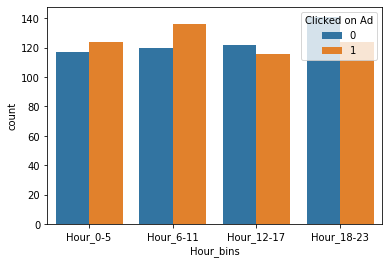

In [57]:
sns.countplot('Hour_bins', hue ='Clicked on Ad', data = new_ad)

In [58]:
#create dummy for this hour bin variable
new_ad = concat([new_ad, get_dummies(new_ad['Hour_bins'], prefix='Hour')], axis=1)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42]),
 <a list of 43 Text xticklabel objects>)

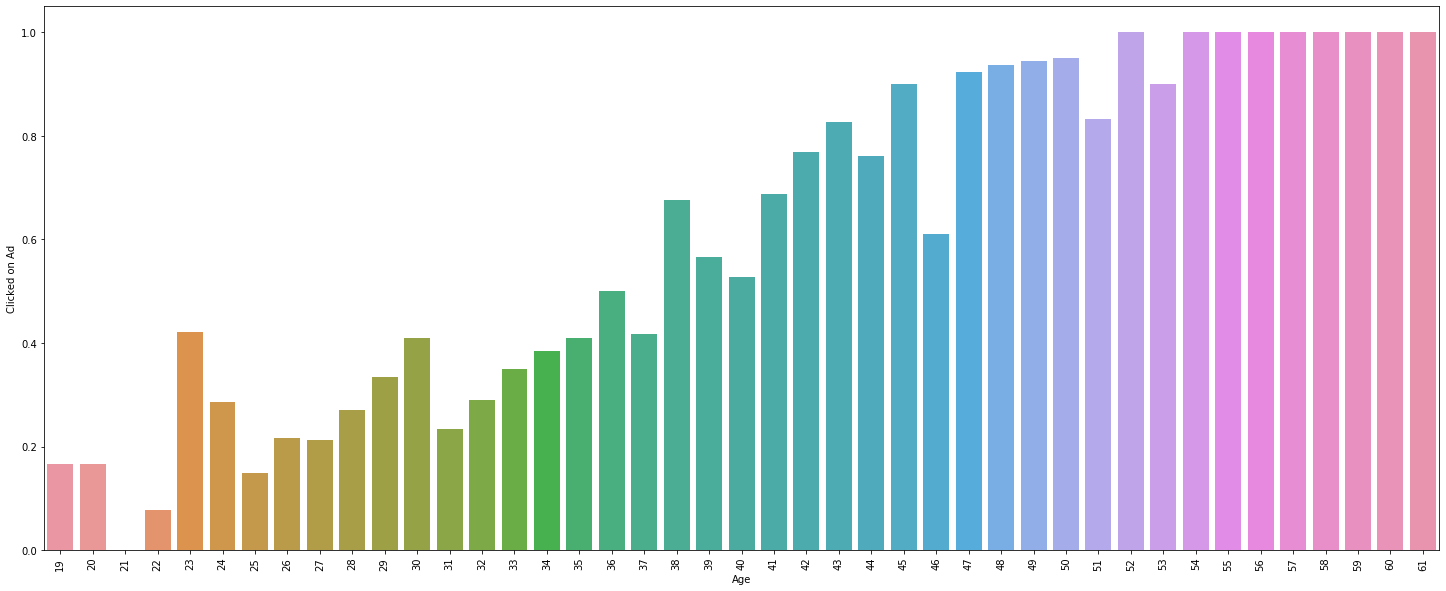

In [46]:
plt.figure(figsize=(25,10))
sns.barplot(new_ad['Age'],new_ad['Clicked on Ad'], ci=None)
plt.xticks(rotation=90)

In [47]:
new_ad ['Age_bins'] = cut(new_ad['Age'], bins=[0,22,35, 55,80],
                         labels = ['College','Adult','Mid','Edler'])

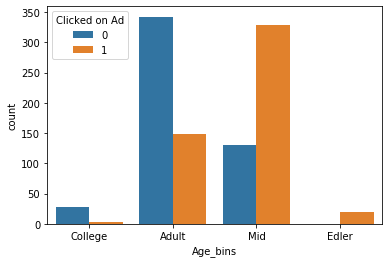

In [48]:
sns.countplot('Age_bins', hue ='Clicked on Ad', data = new_ad)

In [49]:
# dummify the age column
new_ad = concat([new_ad, get_dummies(new_ad['Age_bins'], prefix='Age')], axis=1)

In [50]:
new_ad.columns

Index(['Daily Time Spent on Site', 'Age', 'Area Income',
       'Daily Internet Usage', 'Ad Topic Line', 'City', 'Male', 'Country',
       'Timestamp', 'Clicked on Ad', 'Month', 'Day', 'Hour', 'Weekday', 'Date',
       'Site Weight', 'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5',
       'Month_6', 'Month_7', 'Weekday_0', 'Weekday_1', 'Weekday_2',
       'Weekday_3', 'Weekday_4', 'Weekday_5', 'Weekday_6', 'Hour_bins',
       'Age_bins', 'Age_College', 'Age_Adult', 'Age_Mid', 'Age_Edler'],
      dtype='object')

In [62]:
new_ad.drop(['Age', 'Ad Topic Line', 'City', 'Country', 'Timestamp',
             'Month','Day','Hour','Weekday','Date','Hour_bins','Age_bins'], axis=1, inplace=True)

### Build a logistic Regression based on new features

In [64]:
X = new_ad.drop(['Clicked on Ad'], axis=1)
y = new_ad['Clicked on Ad']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)

In [65]:
#standardizing the features
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

In [75]:
X_train_std_df = DataFrame(X_train_std, columns = X_train.columns)

In [83]:
xnames=X_train.columns

In [92]:
# python statsmodels is

import statsmodels.api as sm
from scipy import stats

X2 = sm.add_constant(X_train_std)
est = sm.OLS(y_train, X2)
est.exog_names[1:] =xnames
est2 = est.fit()
est2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Clicked on Ad   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     198.9
Date:                Tue, 23 Jun 2020   Prob (F-statistic):          1.34e-306
Time:                        15:28:40   Log-Likelihood:                 191.95
No. Observations:                 800   AIC:                            -335.9
Df Residuals:                     776   BIC:                            -223.5
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.4863      0.007     71.159      0.000       0.473       0.500
Daily Time Spent on Site    -0.3904      0.032    -12.241      0.000      -0.453      -0.328
Area Income                 -0.0857      0.008    -11.360      0.000      -0.101      -0.071
Daily Internet Usage        -0.0551      0.032     -1.699      0.090      -0.119       0.009
Male                        -0.0112      0.007     -1.605      0.109      -0.025       0.002
Site Weight                  0.1912      0.031      6.222      0.000       0.131       0.252
Month_1                     -0.0012      0.006     -0.207      0.836      -0.013       0.010
Month_2                     -0.0019      0.006     -0.328      0.743      -0.013       0.010
Month_3                     -0.0138      0.006     -2.363      0.018      -0.025      -0.002
Month_4                      0.0010      0.006      0.168      0.867      -0.011       0.013
Month_5                      0.0046      0.006      0.780      0.436      -0.007       0.016
Month_6                     -0.0019      0.006     -0.312      0.755      -0.014       0.010
Month_7                      0.0157      0.006      2.553      0.011       0.004       0.028
Weekday_0                    0.0105      0.006      1.769      0.077      -0.001       0.022
Weekday_1                   -0.0058      0.006     -0.965      0.335      -0.018       0.006
Weekday_2                   -0.0011      0.006     -0.189      0.850      -0.013       0.010
Weekday_3                   -0.0033      0.006     -0.561      0.575      -0.015       0.008
Weekday_4                   -0.0067      0.006     -1.153      0.249      -0.018       0.005
Weekday_5                   -0.0036      0.006     -0.585      0.559      -0.016       0.008
Weekday_6                    0.0092      0.006      1.580      0.114      -0.002       0.021
Age_College                 -0.0496      0.007     -7.514      0.000      -0.063      -0.037
Age_Adult                   -0.0126      0.004     -3.111      0.002      -0.021      -0.005
Age_Mid                      0.0172      0.004      4.173      0.000       0.009       0.025
Age_Edler                    0.0439      0.007      6.548      0.000       0.031       0.057
Hour_Hour_0-5               -0.0013      0.005     -0.238      0.812      -0.012       0.009
Hour_Hour_6-11               0.0052      0.005      1.014      0.311      -0.005       0.015
Hour_Hour_12-17             -0.0071      0.005     -1.336      0.182      -0.017       0.003
Hour_Hour_18-23              0.0029      0.005      0.565      0.572      -0.007       0.013
==============================================================================
Omnibus:                      278.943   Durbin-Watson:                   1.906
Prob(Omnibus):                  0.000   Ja

In [95]:
#apply logistic regression on training data
lr = LogisticRegression(penalty ='l2', C=0.1, random_state=42)
lr.fit(X_train_std, y_train)

from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
#predict using model
lr_training_pred = lr.predict(X_train_std)
lr_training_prediction = accuracy_score(y_train, lr_training_pred)
print( "Accuracy of Logistic regression training set:",   round(lr_training_prediction,3))

Accuracy of Logistic regression training set: 0.979


C:\Users\miaoxi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [97]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
kf = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(lr, # model
                         X_train_std, # Feature matrix
                         y_train, # Target vector
                         cv=kf, # Cross-validation technique
                         scoring="accuracy", # Loss function
                         n_jobs=-1) # Use all CPU scores
print('10 fold CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

10 fold CV accuracy: 0.971 +/- 0.014


### Random Forest

In [100]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(criterion='gini', n_estimators=400,
                             min_samples_split=10,min_samples_leaf=1,
                             max_features='auto',oob_score=True,
                             random_state=42,n_jobs=-1)
rf.fit(X_train_std,y_train)
# Predict using model
rf_training_pred = rf.predict(X_train_std)
rf_training_prediction = accuracy_score(y_train, rf_training_pred)

print("Accuracy of Random Forest training set:",   round(rf_training_prediction,3))

Accuracy of Random Forest training set: 0.986


In [101]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(rf, # model
                         X_train_std, # Feature matrix
                         y_train, # Target vector
                         cv=kf, # Cross-validation technique
                         scoring="accuracy", # Loss function
                         n_jobs=-1) # Use all CPU scores
print('10 fold CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

10 fold CV accuracy: 0.966 +/- 0.020


### Random Forest Feature Importance

In [108]:
feature_importances = DataFrame(rf.feature_importances_,
                                index = X_train.columns,
                                columns=['importance']).sort_values(
    'importance', ascending= False).reset_index()
feature_importances.head(10)

,index,importance
0,Daily Internet Usage,0.381573
1,Daily Time Spent on Site,0.305498
2,Area Income,0.113998
3,Site Weight,0.087187
4,Age_Adult,0.031923
5,Age_Mid,0.030050
6,Age_Edler,0.008783
7,Age_College,0.008200
8,Male,0.002678
9,Weekday_3,0.002136


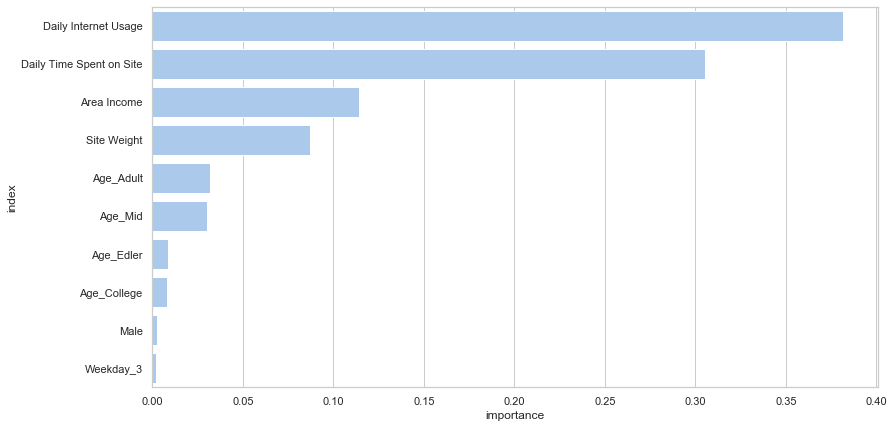

In [109]:
#visualize
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(13, 7))

# Plot the Feature Importance
sns.set_color_codes("pastel")
sns.barplot(x="importance", y='index', data=feature_importances[0:10],
            label="Total", color="b")

### Recommendations

With the exploration, we can describe the preferred candidate as people who:
overall spend less time on internet, older with lower area income;
The actual benefit of using tree models is not obvious in this case